# HK Models Comparison

- Original HK
- HK with random sampling
- HK with a graph

See G(N,p) comarison for description.

In [6]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from numpy import diag
import numpy.random as rand
from numpy.linalg import norm, inv, eigvals

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat
import pandas as pd

import models
from util import *
from viz import *

plt.rcParams['figure.figsize'] = (12.0, 9.0)

In [7]:
def list_stats(my_list):
    return '{0} values (min: {1}, max: {2})'.format(len(my_list), min(my_list), max(my_list))

In [8]:
rand.seed(44124)
N = 256
max_rounds = 10e3

# Generate values for ε > 0.01 so that we can accurately measure cluster number
EPS_POINTS = 20
eps_list = np.linspace(0.01, 0.4, EPS_POINTS)

# Generate random opinion vectors
#s = rand.rand(N)
SIM_NUM = 40
s_list = [rand.rand(N) for _ in xrange(SIM_NUM)]

# Generate dfferent values of K
K_MIN = np.ceil(np.log10(N))
K_MAX = np.ceil(N * 0.2)
k_list = np.arange(K_MIN, K_MAX, 3).astype(int)
# Generate p_list
p_list = k_list / N

print('[+] N: {0}'.format(N))
print('[+] eps: {0}'.format(list_stats(eps_list)))
print('[+] s: {0} random values'.format(SIM_NUM))
print('[+] p: {0}'.format(list_stats(p_list)))
print('[+] K: {0}'.format(list_stats(k_list)))

[+] N: 256
[+] eps: 20 values (min: 0.01, max: 0.4)
[+] s: 40 random values
[+] p: 17 values (min: 0.01171875, max: 0.19921875)
[+] K: 17 values (min: 3, max: 51)


In [9]:
def run_models(s):
    import models
    from util import cluster_count, cluster_count_net
    from numpy.linalg import norm
    import numpy as np
    
    result = tuple()
    # Original HK
    op_hk = models.hk(s, op_eps, max_rounds)
    time_hk = op_hk.shape[0]
    clusters_hk = cluster_count(op_hk[-1, :], op_eps)
    # HK Random Sampling
    op_rand = models.hk_rand(s, K, op_eps, max_rounds)
    time_rand = op_rand.shape[0]
    clusters_rand = cluster_count(op_rand[-1, :], op_eps)
    # HK with a network
    time_local, z_local = models.hk_local_nomem(A, s, op_eps, max_rounds)
    clusters_local = cluster_count_net(A, z_local, op_eps)
    # Calculate differences in number of clusters
    cdiff_1 = abs(clusters_hk-clusters_rand)
    cdiff_2 = abs(clusters_hk-clusters_local)
    # Calculate differences in opinion values (2-norm)
    ndiff_1 = norm(op_hk[-1] - op_rand[-1])
    ndiff_2 = norm(op_hk[-1] - z_local)
    # Create result tuple
    result += (time_hk, clusters_hk)
    result += (time_rand, clusters_rand, cdiff_1, ndiff_1)
    result += (time_local, clusters_local, cdiff_2, ndiff_2)
    return result

def calculate_averages(tuple_list):
    tuple_elems = len(tuple_list[0])
    averages = np.zeros(tuple_elems)
    num_elem = len(tuple_list)
    for t in tuple_list:
        for i in xrange(tuple_elems):
            averages[i] += t[i] / num_elem
    averages = np.round(averages)
    return averages.astype(int)

In [10]:
v, dv = parallel_init('/home/user/opinions-research/', profile='default')

[*] 8 parallel engines available
[*] Finished setting working directories


In [11]:
# Run Models
data = np.empty((0, 7))
t = tqdm(total=len(k_list) * EPS_POINTS)
# res: model_id, eps, K, time, clusters, cluster_diff, norm_diff
dv.clear()
for i, p in enumerate(p_list):
    K = k_list[i]
    A = barabasi_albert(N, K, None, verbose=False)
    ar = dv.push(dict(max_rounds=max_rounds, A=A, K=K))
    ar.get()     
    for eps in eps_list:
        ar = dv.push(dict(op_eps=eps))
        ar.get()
        result = parallel_map(v, run_models, s_list, silent=True)
        avg_result = calculate_averages(result)
        res_hk = np.array([0, eps, 0, avg_result[0], avg_result[1], 0, 0])
        res_rand = np.array([1, eps, K])
        res_rand = np.hstack((res_rand, avg_result[2:6]))
        res_local = np.array([2, eps, K])
        res_local = np.hstack((res_local, avg_result[6:10]))
        data = np.vstack((data, res_hk, res_rand, res_local))
        t.update()
t.close()

In [12]:
# Create DataFrame
df = pd.DataFrame(data=data, columns=['model_id', 'eps', 'K', 'rounds', 'clusters', 'cluster_diff', 'norm_diff'])
# Convert column types
df['K'] = df['K'].astype(int)
df['model_id'] = df['model_id'].astype(int)
df['model'] = 'hk'
df.loc[df['model_id'] == 1, 'model'] = 'rand'
df.loc[df['model_id'] == 2, 'model'] = 'local'

In [13]:
# Create 'eps_range' column
NUM_CUTS = 6
eps_cut = pd.cut(df['eps'], NUM_CUTS, precision=2, right=False)
df['eps_range'] = eps_cut
#df['eps_range'] = df['eps_range'].astype('category', ordered='True')

In [14]:
df.to_csv('hk_comparisons3.csv')

In [15]:
# Read already saved DataFrame
df = pd.read_csv('hk_comparisons3.csv')

# Comparison of Convergence Times

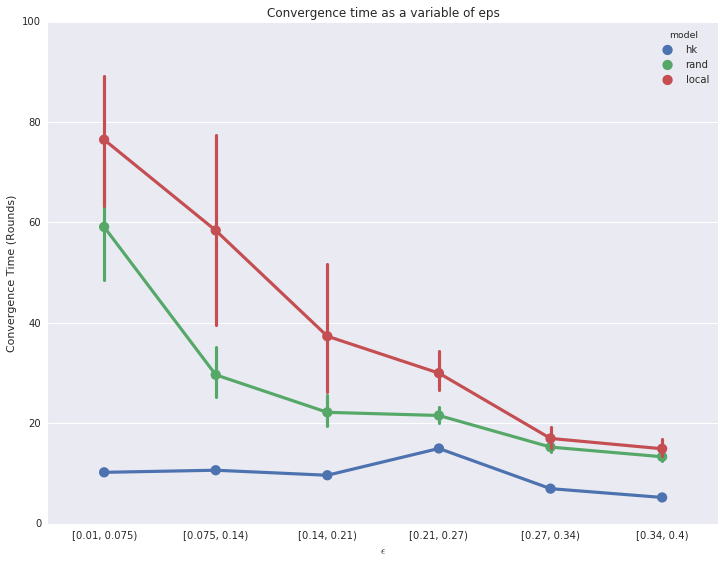

In [23]:
sns.pointplot(x='eps_range', y='rounds', data=df, hue='model', ylim=(0, 140))
plt.xlabel('$\epsilon$')
plt.ylabel('Convergence Time (Rounds)')
plt.title('Convergence time as a variable of eps')
plt.show()

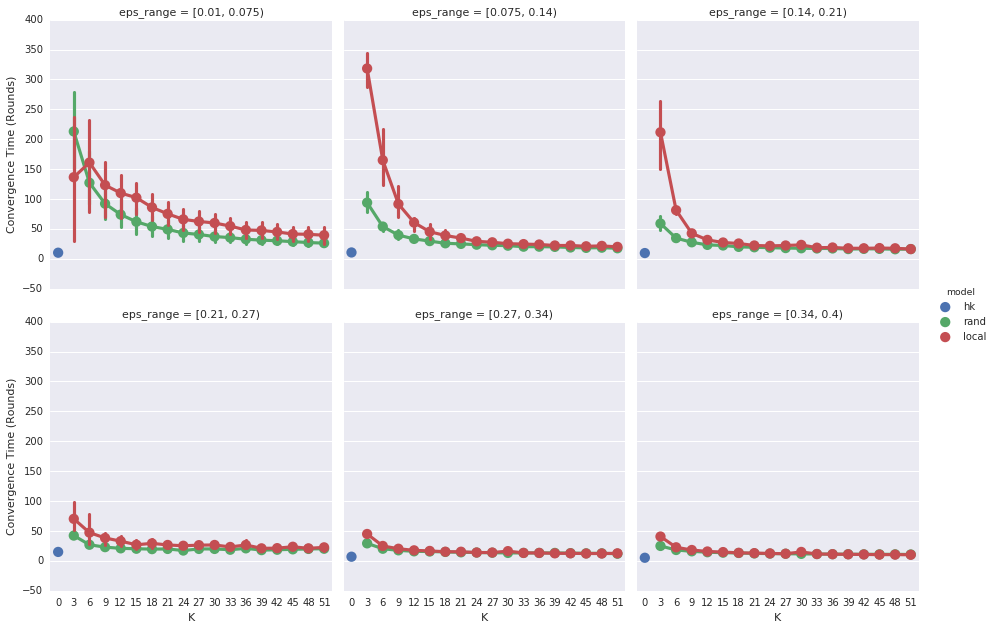

In [17]:
g = sns.factorplot(x='K', y='rounds', hue='model', data=df, col='eps_range', col_wrap=3)
g.set_ylabels('Convergence Time (Rounds)')
fig = plt.gcf()
fig.set_size_inches(14, 9)
plt.show()

# Number of clusters 
- Every Model
- Dependent on ε

For detailed ranges of eps see the labels above because there is not enough space here

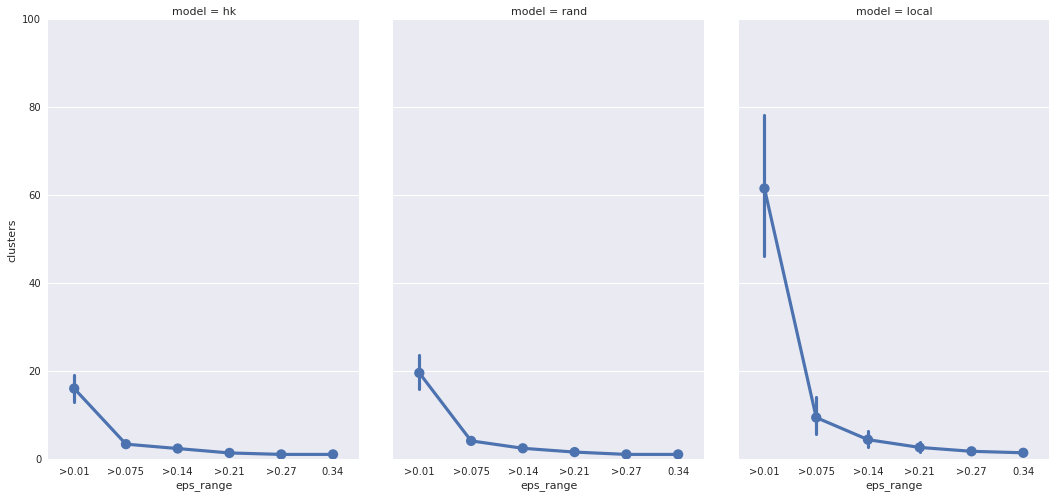

In [18]:
g = sns.factorplot(x='eps_range', y='clusters', col='model', data=df)
g.set(ylim=(0, 100))
g.set_xticklabels(['>0.01', '>0.075', '>0.14', '>0.21', '>0.27','0.34'])
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

# Number of clusters 

- By Model
- Dependent on K

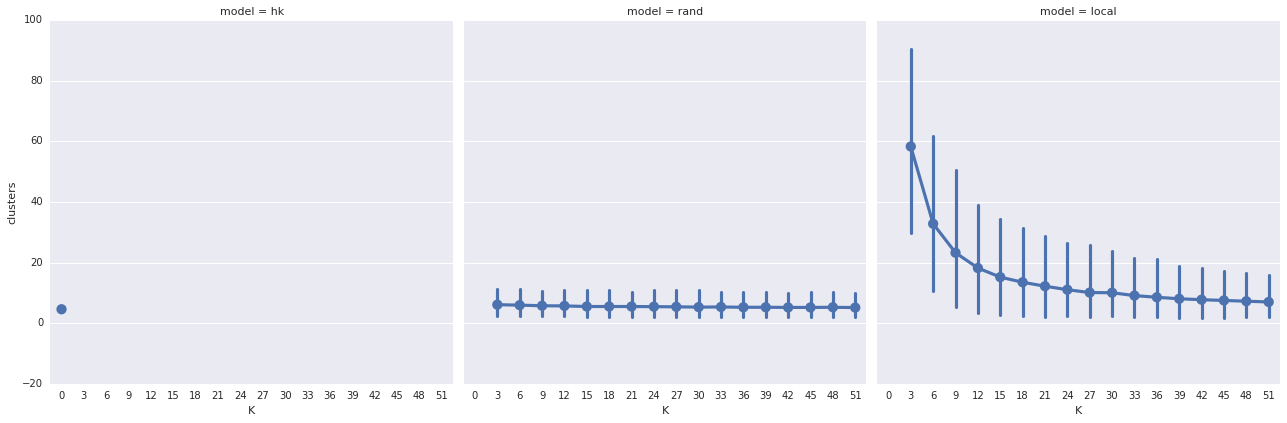

In [19]:
sns.factorplot(x='K', y='clusters', data=df, col='model', size=6)
plt.show()

# Number of clusters 

- Every Model
- Dependent on K
- Dependent on range of ε

#### Legend
- x-axis: K
- y-axis: number of clusters
- graphs column: type of model
- graphs row: eps_range

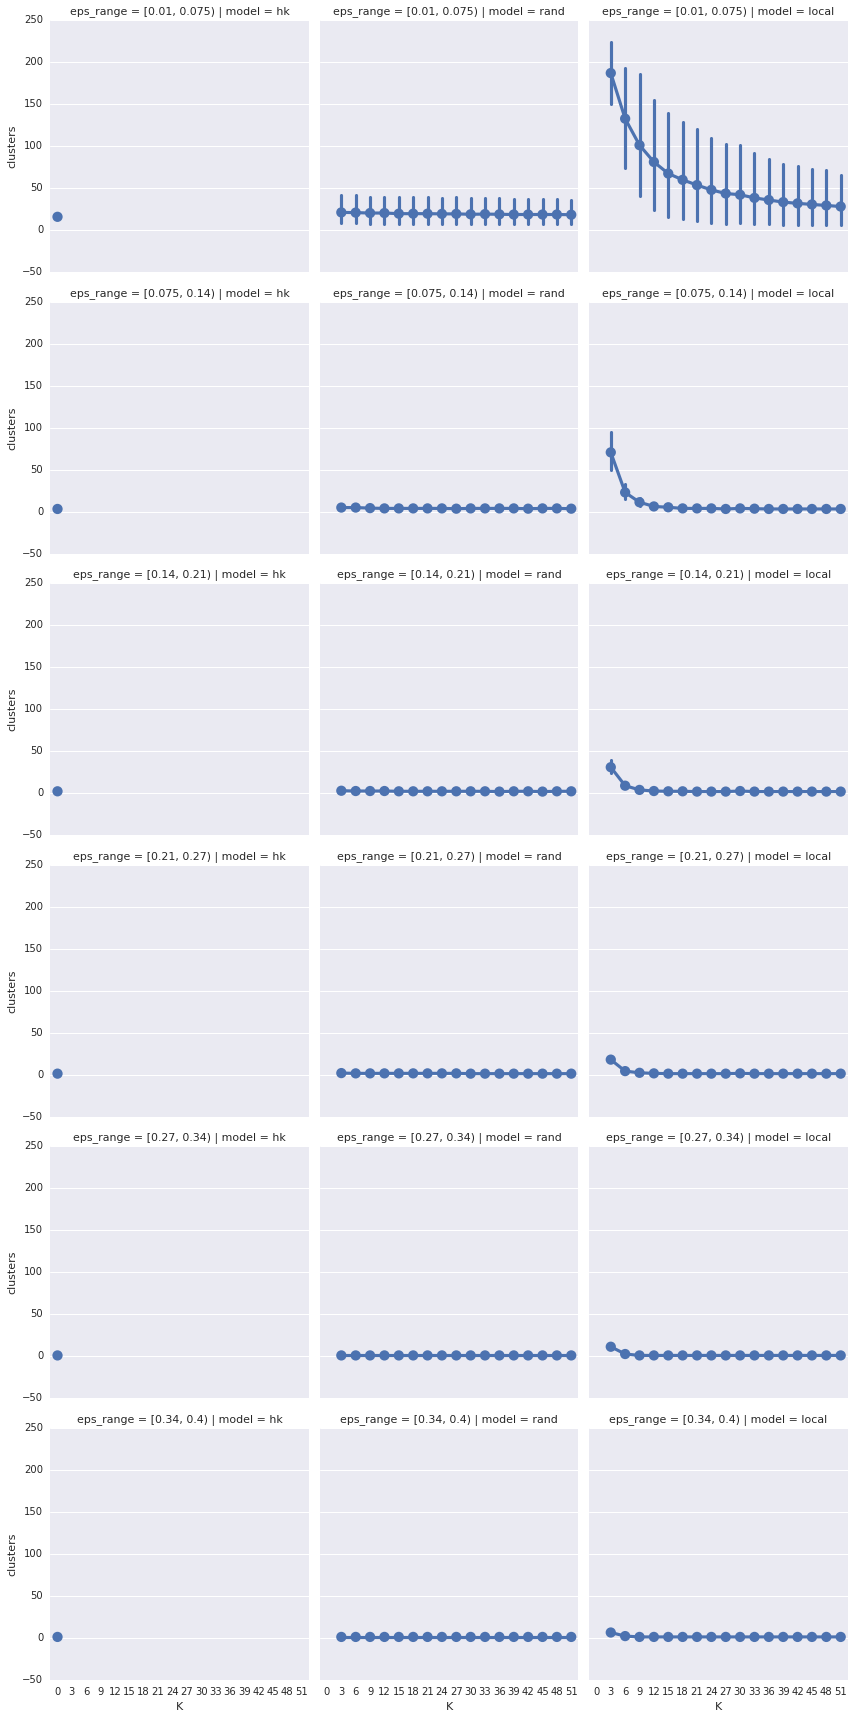

In [20]:
sns.factorplot(x='K', y='clusters', data=df, col='model', row='eps_range')
plt.show()

# Normalized $L_{2}$ distance of final opinions

- Distance of opinion vectors divided by the number of clusters

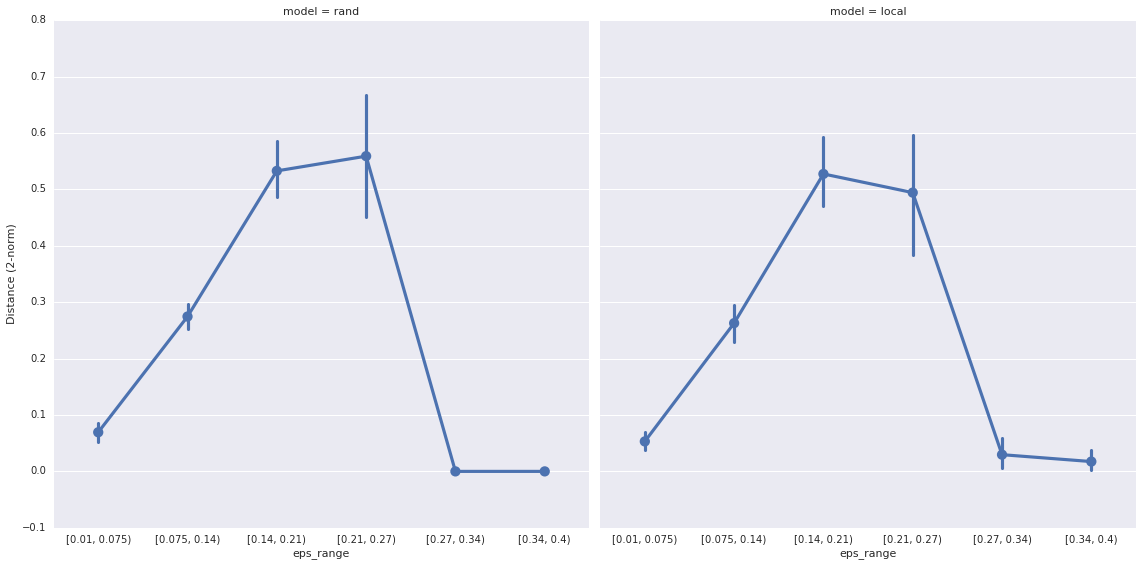

In [21]:
df['dist2'] = df['norm_diff'] / df['clusters']
g = sns.factorplot(x='eps_range', y='dist2', data=df[df['model'] != 'hk'], col='model', size=8)
g.set_ylabels('Distance (2-norm)')
plt.show()

# More detailed

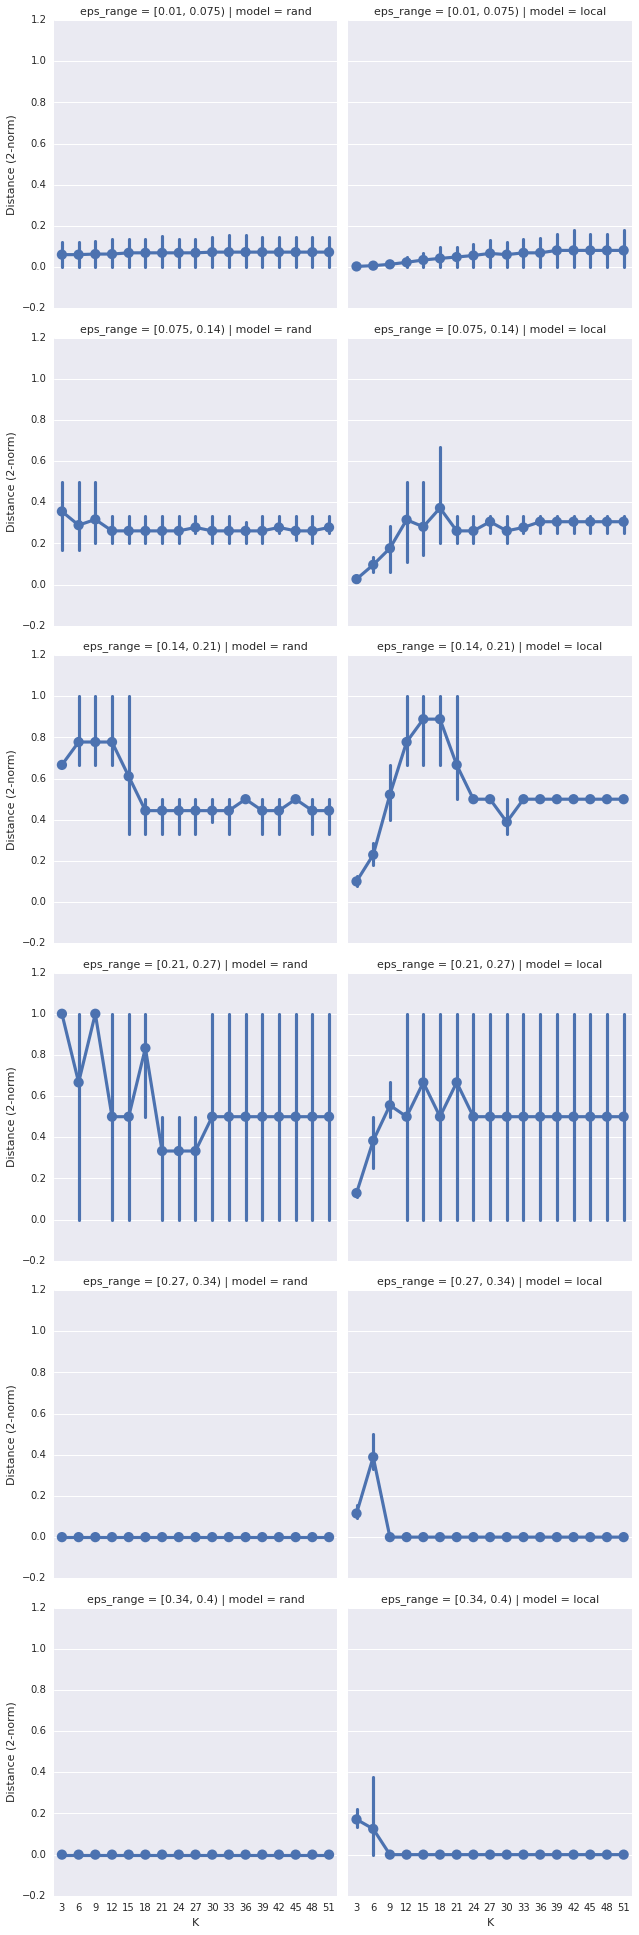

In [22]:
g = sns.factorplot(x='K', y='dist2', data=df[df['K'] > 0], col='model', row='eps_range', size=4.5)
g.set_ylabels('Distance (2-norm)')
plt.show()